In [54]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from skimage.feature import hog
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray
from scipy.spatial.distance import cdist
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import color, exposure
from skimage.io import imread
from skimage.transform import resize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTForImageClassification, ViTImageProcessor
import requests
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms.functional as F
from collections import Counter
from sklearn.utils import resample


# 1- Charging and exploring the data

In [2]:
dataset_path = "chest_xray"

# Define the subdirectories for train, test, and validation
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

In [3]:
COUNT_NORMAL = {"train": 0, "test": 0, "val": 0}
COUNT_PNEUMONIA = {"train": 0, "test": 0, "val": 0}

def load_and_preprocess_images(folder_path, label, split):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize the image
            img = np.array(img) / 255.0  # Normalize between 0 and 1
            images.append(img)
            labels.append(label)
            
            # Update counts
            if label == 0:  # NORMAL
                COUNT_NORMAL[split] += 1
            else:  # PNEUMONIA
                COUNT_PNEUMONIA[split] += 1
                
        except Exception as e:
            print(f"Corrupted image: {file_path}, error: {e}")
    return images, labels

In [4]:
data = {"train": [], "test": [], "val": []}
labels = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, lbls = load_and_preprocess_images(folder_path, category_label, subdir)
        data[subdir].extend(images)
        labels[subdir].extend(lbls)

# Conversion en numpy arrays et ajout de la dimension canal (pour CNN)
for key in data:
    data[key] = np.expand_dims(np.array(data[key]), axis=-1)  
    labels[key] = np.array(labels[key])


In [5]:
print(f"COUNT_NORMAL in train: {COUNT_NORMAL['train']}")
print(f"COUNT_PNEUMONIA in train: {COUNT_PNEUMONIA['train']}")
print(f"COUNT_NORMAL in test: {COUNT_NORMAL['test']}")
print(f"COUNT_PNEUMONIA in test: {COUNT_PNEUMONIA['test']}")
print(f"COUNT_NORMAL in val: {COUNT_NORMAL['val']}")
print(f"COUNT_PNEUMONIA in val: {COUNT_PNEUMONIA['val']}")

COUNT_NORMAL in train: 1341
COUNT_PNEUMONIA in train: 3875
COUNT_NORMAL in test: 234
COUNT_PNEUMONIA in test: 390
COUNT_NORMAL in val: 8
COUNT_PNEUMONIA in val: 8


In [6]:
data["train"] = np.array(data["train"])
labels["train"] = np.array(labels["train"])
data["test"] = np.array(data["test"])
labels["test"] = np.array(labels["test"])
data["val"] = np.array(data["val"])
labels["val"] = np.array(labels["val"])

print("Data loaded successfully!")
print(f"Train data shape: {data['train'].shape}, Train labels shape: {labels['train'].shape}")
print(f"Test data shape: {data['test'].shape}, Test labels shape: {labels['test'].shape}")
print(f"Validation data shape: {data['val'].shape}, Validation labels shape: {labels['val'].shape}")

Data loaded successfully!
Train data shape: (5216, 128, 128, 1), Train labels shape: (5216,)
Test data shape: (624, 128, 128, 1), Test labels shape: (624,)
Validation data shape: (16, 128, 128, 1), Validation labels shape: (16,)


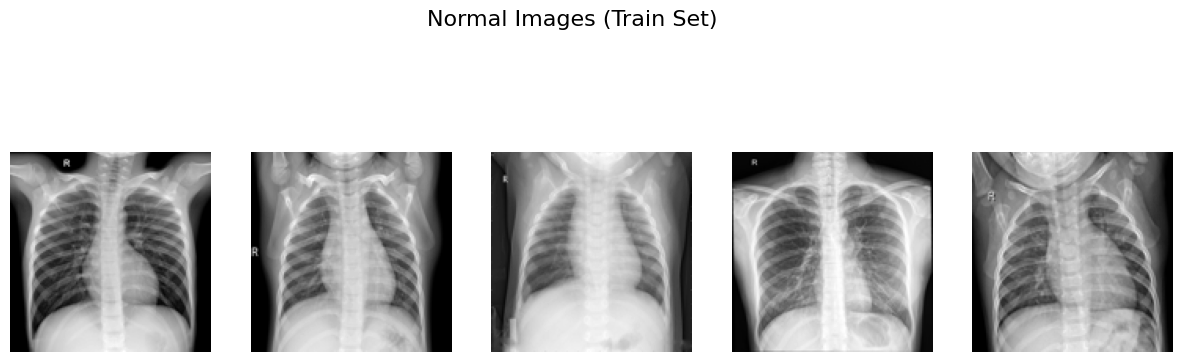

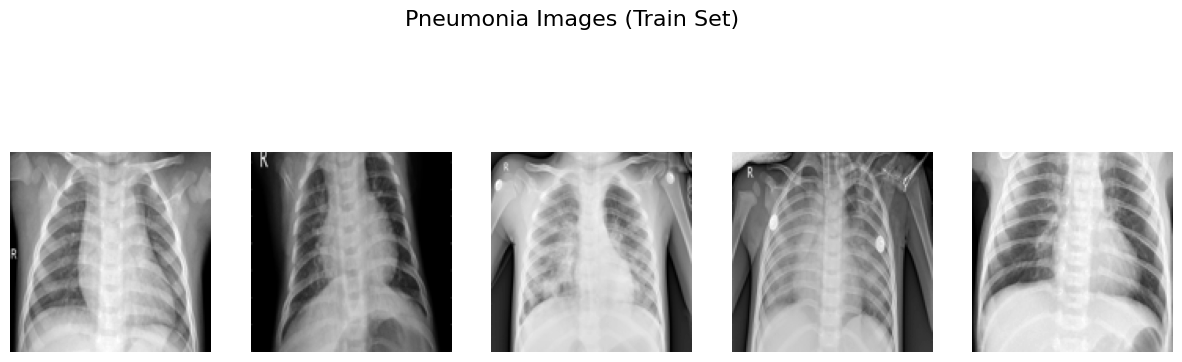

In [7]:
# Function to plot images
def plot_images(data, labels, category_label, title, n=5):

    # Filter the images for the specified category (NORMAL or PNEUMONIA)
    category_images = [data[i] for i in range(len(labels)) if labels[i] == category_label]
    
    # Select random images
    selected_indices = [randint(0, len(category_images) - 1) for _ in range(n)]
    selected_images = [category_images[i] for i in selected_indices]
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(selected_images):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Plot NORMAL images
plot_images(data["train"], labels["train"], category_label=0, title="Normal Images (Train Set)", n=5)

# Plot PNEUMONIA images
plot_images(data["train"], labels["train"], category_label=1, title="Pneumonia Images (Train Set)", n=5)


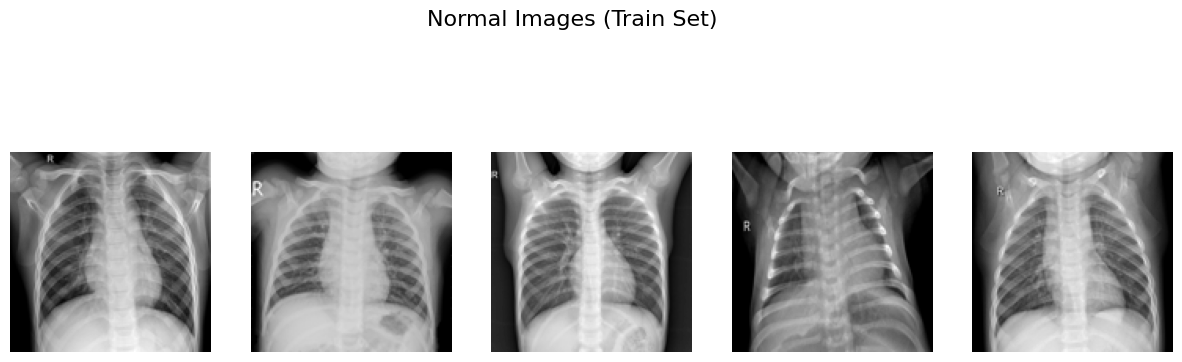

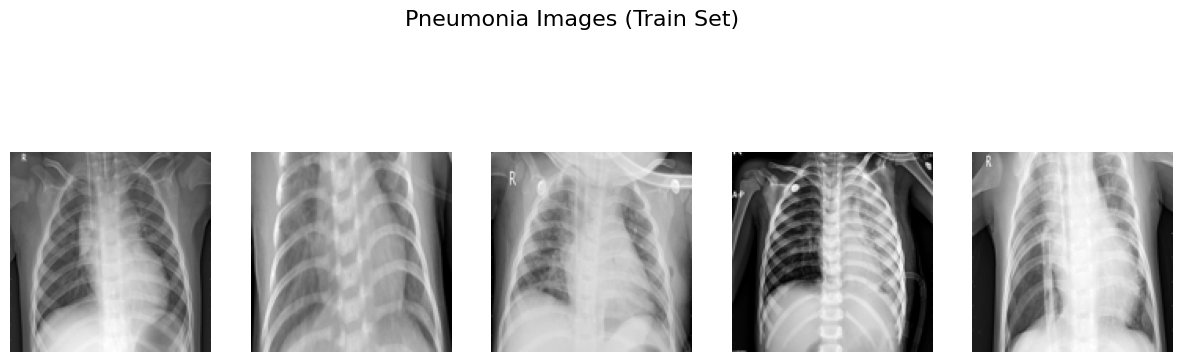

In [8]:
def plot_images(data, labels, category_label, title, n=5):
    category_images = [data[i] for i in range(len(labels)) if labels[i] == category_label]
    selected_images = [category_images[i] for i in np.random.choice(len(category_images), n, replace=False)]
    
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(selected_images):
        plt.subplot(1, n, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Afficher des images de chaque catégorie
plot_images(data["train"], labels["train"], category_label=0, title="Normal Images (Train Set)")
plot_images(data["train"], labels["train"], category_label=1, title="Pneumonia Images (Train Set)")


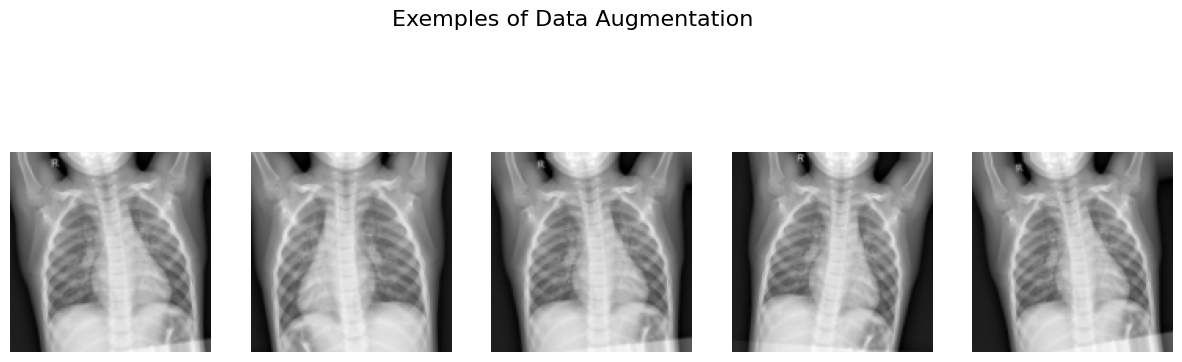

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range=0.1,  
    horizontal_flip=True  
)

# Exemple d’augmentation d’une image
sample_img = np.expand_dims(data["train"][0], axis=0)  
augmented_images = [datagen.flow(sample_img, batch_size=1)[0].squeeze() for _ in range(5)]

# Affichage des images augmentées
plt.figure(figsize=(15, 5))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Exemples of Data Augmentation", fontsize=16)
plt.show()


# Comparaison des Performances des Modèles pour Chaque Descripteur et Analyse des Résultats entre les Descripteurs

# 1-HOG (Histogram of gradients)

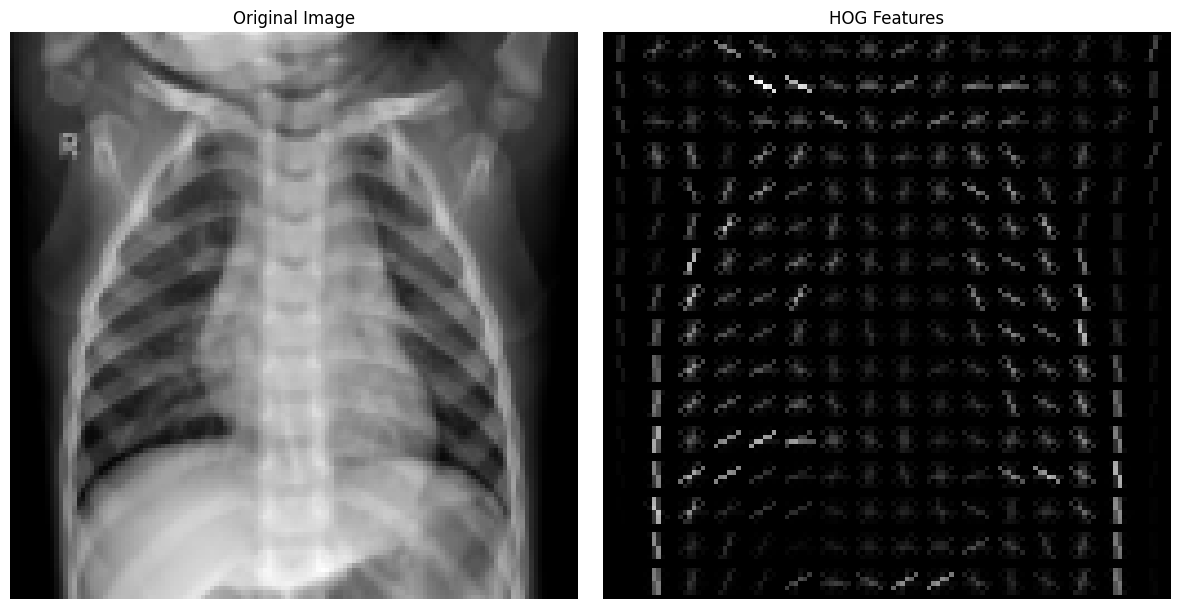

HOG Feature Vector Shape: (8100,)


In [10]:

def extract_hog_features(image_path):

    # Load the image
    image = imread(image_path)
    
    # Convert to grayscale if necessary
    if len(image.shape) == 3:  # If the image has 3 channels (RGB)
        image = rgb2gray(image)
    
    # Resize the image to a standard size (optional but recommended)
    # This ensures consistency in HOG feature dimensions
    from skimage.transform import resize
    image_resized = resize(image, (128, 128))  # Resize to 128x128 pixels
    
    # Extract HOG features
    feature_vector, hog_image = hog(
        image_resized,
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True, 
        feature_vector=True
    )
    
    # Plot the original and HOG images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(hog_image, cmap='gray')
    ax[1].set_title("HOG Features")
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return feature_vector, hog_image

# Example usage
image_path = "chest_xray/train/NORMAL/IM-0117-0001.jpeg" 
hog_features, hog_visualization = extract_hog_features(image_path)
print("HOG Feature Vector Shape:", hog_features.shape)


## Ajustement des paramètres pour réduire la taille des features

In [13]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Vérifier et convertir en niveaux de gris si nécessaire
        if img.ndim == 3 and img.shape[-1] == 3:  
            img = rgb2gray(img)  
        
        # Réduction de dimension si (128,128,1)
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()  
        
        # Extraire les caractéristiques HOG avec des paramètres optimisés
        features = hog(img, 
                       orientations=6,  # Réduit le nombre de directions
                       pixels_per_cell=(16, 16),  # Agrandit la taille des cellules
                       cells_per_block=(1, 1),  # Évite la redondance
                       block_norm='L2-Hys',
                       feature_vector=True)
        
        hog_features.append(features)
    
    return np.array(hog_features)

train_hog = extract_hog_features(data["train"])
test_hog = extract_hog_features(data["test"])
val_hog = extract_hog_features(data["val"])

print("Taille des features HOG :", train_hog.shape[1])


Taille des features HOG : 384


## Tester le KNN avec les meilleurs paramètres et K-folds pour la détermination du K

 Best k found: 11 with metric 'manhattan' (CV Accuracy: 95.42%)

 Test Accuracy (kNN with manhattan distance, k=11): 77.24%

Classification Report (kNN) on Test Set:
              precision    recall  f1-score   support

      NORMAL       0.93      0.43      0.58       234
   PNEUMONIA       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.83      0.70      0.71       624
weighted avg       0.81      0.77      0.75       624



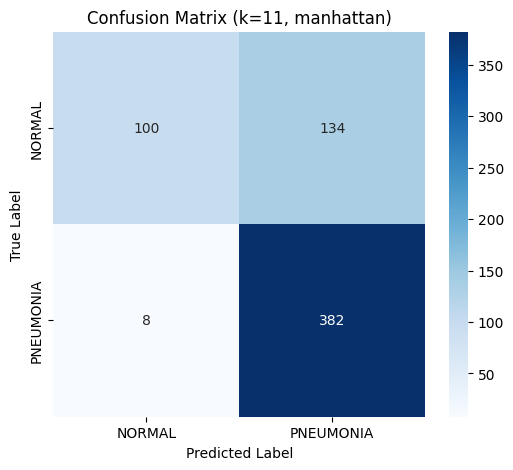

In [52]:
# Standardize features 
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_hog)
test_features = scaler.transform(test_hog)

# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, train_features, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")

# Train final model with best parameters
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(train_features, labels["train"])

# Evaluate on TEST set
test_predictions = knn.predict(test_features)
test_accuracy = accuracy_score(labels["test"], test_predictions)

print(f"\n Test Accuracy (kNN with {best_metric} distance, k={best_k}): {test_accuracy * 100:.2f}%")
print("\nClassification Report (kNN) on Test Set:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


Best k found: 13 with metric 'manhattan' (CV Accuracy: 95.74%) using 15-fold cross-validation

Test Accuracy (kNN with manhattan distance, k=13): 77.88%

Classification Report (kNN) on Test Set:
              precision    recall  f1-score   support

      NORMAL       0.94      0.44      0.60       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



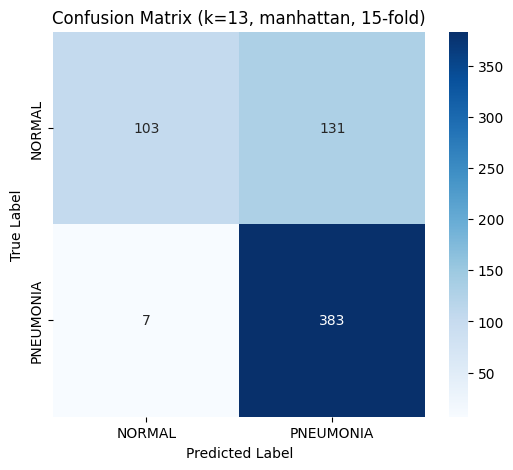

In [53]:

split_values = [3, 5, 7, 10, 15]  
# Best model tracking
best_k = None
best_metric = None
best_score = 0
best_splits = None

# Cross-validation loop
for metric in distance_metrics:
    for k in k_values:
        for splits in split_values:
            cv = StratifiedKFold(n_splits=splits)  # Using different split values
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_val_score(knn, train_features, labels["train"], cv=cv, scoring="accuracy")
            mean_score = scores.mean()
            
            if mean_score > best_score:
                best_score = mean_score
                best_k = k
                best_metric = metric
                best_splits = splits

print(f"Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%) using {best_splits}-fold cross-validation")

# Train final model with best parameters
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(train_features, labels["train"])

# Evaluate on TEST set
test_predictions = knn.predict(test_features)
test_accuracy = accuracy_score(labels["test"], test_predictions)

print(f"\nTest Accuracy (kNN with {best_metric} distance, k={best_k}): {test_accuracy * 100:.2f}%")
print("\nClassification Report (kNN) on Test Set:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric}, {best_splits}-fold)")
plt.show()


## Undersampling pour équilibrer le jeu de données

In [ ]:
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sous-échantillonnage de la classe majoritaire (PNEUMONIA)
X_train_pneumonia_undersampled, y_train_pneumonia_undersampled = resample(
    X_train_pneumonia, 
    labels["train"][labels["train"] == 1], 
    replace=False, 
    n_samples=X_train_normal.shape[0],  # Égale la taille de la classe minoritaire
    random_state=42
)

# Combiner les données sous-échantillonnées avec les données de la classe normale
X_train_balanced = np.vstack([X_train_normal, X_train_pneumonia_undersampled])
y_train_balanced = np.hstack([labels["train"][labels["train"] == 0], y_train_pneumonia_undersampled])

# Vérifier l'équilibre des classes après undersampling
print(f"Classe NORMAL: {np.sum(y_train_balanced == 0)}")
print(f"Classe PNEUMONIA: {np.sum(y_train_balanced == 1)}")


Classe NORMAL: 1341
Classe PNEUMONIA: 1341


## KNN avec les données équilibrées

Meilleur k trouvé : 5 avec une précision de validation croisée : 93.21%
Précision sur le jeu de test (kNN) : 82.69%
Classification Report (kNN) sur le jeu de test :
              precision    recall  f1-score   support

      NORMAL       0.85      0.65      0.74       234
   PNEUMONIA       0.82      0.93      0.87       390

    accuracy                           0.83       624
   macro avg       0.83      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624



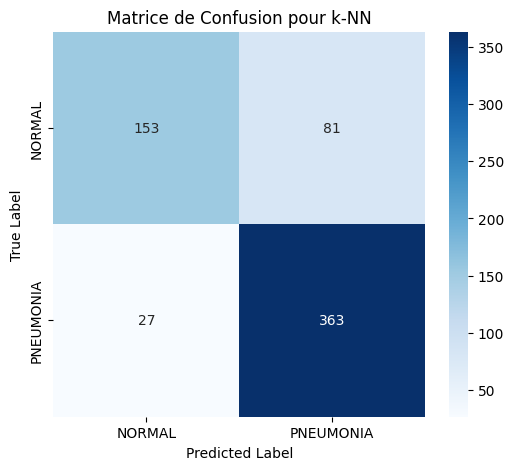

In [55]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(test_features)

best_k = 1
best_score = 0
k_values = range(1, 21, 2)  

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')  # Utilisation de la distance Manhattan
    cv = StratifiedKFold(n_splits=15)  
    scores = cross_val_score(knn, X_train_scaled, y_train_balanced, cv=cv, scoring="accuracy")
    mean_score = scores.mean()
    
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Meilleur k trouvé : {best_k} avec une précision de validation croisée : {best_score * 100:.2f}%")

# 4. Entraînement du modèle kNN avec le meilleur k
knn = KNeighborsClassifier(n_neighbors=best_k, metric='manhattan')
knn.fit(X_train_scaled, y_train_balanced)

# 5. Prédiction sur les données de test
test_predictions = knn.predict(X_test_scaled)

# 6. Calcul de la précision (accuracy) sur les données de test
test_accuracy = accuracy_score(labels["test"], test_predictions)
print(f"Précision sur le jeu de test (kNN) : {test_accuracy * 100:.2f}%")

# 7. Classification Report sur les données de test
print("Classification Report (kNN) sur le jeu de test :")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# 8. Matrice de confusion
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matrice de Confusion pour k-NN")
plt.show()


## Oversampling pour réduire les non-détection 

In [ ]:
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sur-échantillonnage de la classe normal
X_train_normal_oversampled, y_train_normal_oversampled = resample(
    X_train_normal, 
    labels["train"][labels["train"] == 0], 
    replace=True,  # Permet de dupliquer les échantillons
    n_samples=X_train_pneumonia.shape[0],  # Égalise la taille de la classe "pneumonia"
    random_state=42
)

# Combiner les données sur-échantillonnées avec les données de la classe pneumonia
X_train_balanced = np.vstack([X_train_normal_oversampled, X_train_pneumonia])
y_train_balanced = np.hstack([y_train_normal_oversampled, labels["train"][labels["train"] == 1]])

# Vérifier l'équilibre des classes après oversampling
print(f"Classe NORMAL (oversampled): {np.sum(y_train_balanced == 0)}")
print(f"Classe PNEUMONIA: {np.sum(y_train_balanced == 1)}")


Classe NORMAL (oversampled): 3875
Classe PNEUMONIA: 3875


Précision sur le jeu de test (kNN) : 83.49%
Classification Report (kNN) sur le jeu de test :
              precision    recall  f1-score   support

      NORMAL       0.91      0.62      0.74       234
   PNEUMONIA       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.83      0.83       624



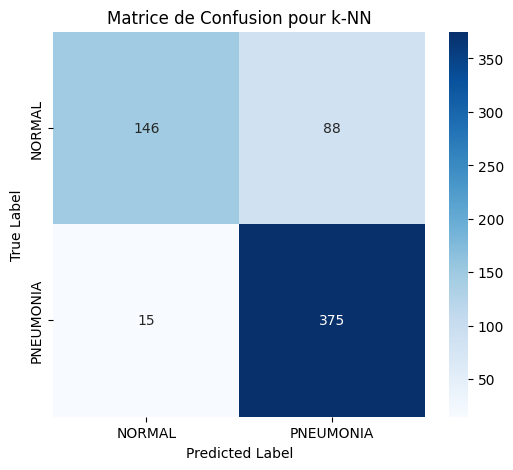

In [63]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(test_features)

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(X_train_scaled, y_train_balanced)

# 5. Prédiction sur les données de test
test_predictions = knn.predict(X_test_scaled)

# 6. Calcul de la précision (accuracy) sur les données de test
test_accuracy = accuracy_score(labels["test"], test_predictions)
print(f"Précision sur le jeu de test (kNN) : {test_accuracy * 100:.2f}%")

# 7. Classification Report sur les données de test
print("Classification Report (kNN) sur le jeu de test :")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# 8. Matrice de confusion
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matrice de Confusion pour k-NN")
plt.show()


### Conclusion :
- Le modèle semble bien fonctionner pour la classe PNEUMONIA, avec un rappel élevé (96%), ce qui signifie que très peu de cas de pneumonie sont manqués.
- Par contre, pour la classe NORMAL, le modèle a une précision élevée (91%), mais son rappel est relativement plus faible (62%), indiquant qu'il manque un nombre significatif de cas "NORMAL". Cela est probablement dû à l'oversampling de la classe NORMAL, qui peut entraîner une certaine confusion avec la classe PNEUMONIA.

## Naive Bayes model avec HOG

Best prior found: None (CV Accuracy: 87.12%)

Test Accuracy (Naive Bayes with prior=None): 73.56%

Classification Report (Naive Bayes) on Test Set:
              precision    recall  f1-score   support

      NORMAL       0.72      0.48      0.58       234
   PNEUMONIA       0.74      0.89      0.81       390

    accuracy                           0.74       624
   macro avg       0.73      0.69      0.69       624
weighted avg       0.73      0.74      0.72       624



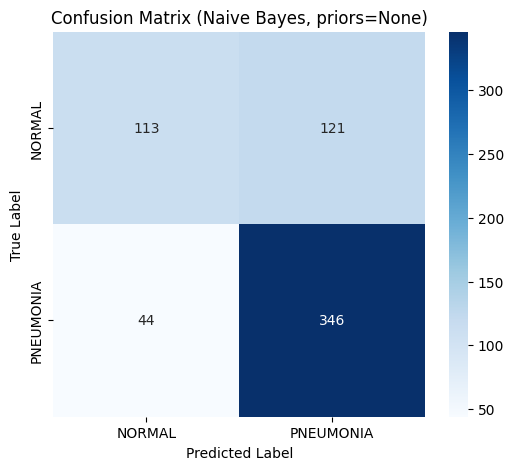

In [ ]:
# Standardize features
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_hog)
test_features = scaler.transform(test_hog)

nb = GaussianNB()
nb.fit(train_features, labels["train"])

# Evaluate on TEST set
test_predictions = nb.predict(test_features)
test_accuracy = accuracy_score(labels["test"], test_predictions)

print(f"\nTest Accuracy (Naive Bayes with prior={best_prior}): {test_accuracy * 100:.2f}%")
print("\nClassification Report (Naive Bayes) on Test Set:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Naive Bayes, priors={best_prior})")
plt.show()


## Naive bayse avec data undersampled 


Test Accuracy (Naive Bayes - Undersampled): 73.72%

Classification Report (Naive Bayes) on Test Set (Undersampled):
              precision    recall  f1-score   support

      NORMAL       0.72      0.49      0.58       234
   PNEUMONIA       0.74      0.89      0.81       390

    accuracy                           0.74       624
   macro avg       0.73      0.69      0.70       624
weighted avg       0.73      0.74      0.72       624



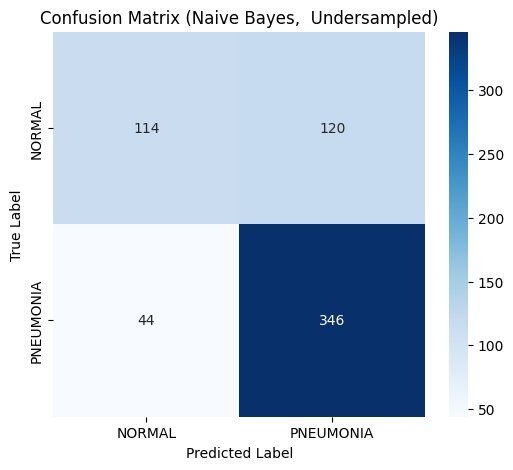

In [73]:

# Sous-échantillonnage des données
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sous-échantillonnage de la classe pneumonia
X_train_pneumonia_undersampled, y_train_pneumonia_undersampled = resample(
    X_train_pneumonia,
    labels["train"][labels["train"] == 1],
    replace=False,  # Ne permet pas de dupliquer les échantillons
    n_samples=X_train_normal.shape[0],  # Égalise la taille de la classe "normal"
    random_state=42
)

# Combiner les données sous-échantillonnées avec les données de la classe normal
X_train_balanced_undersampled = np.vstack([X_train_normal, X_train_pneumonia_undersampled])
y_train_balanced_undersampled = np.hstack([labels["train"][labels["train"] == 0], y_train_pneumonia_undersampled])

# Standardisation des données
scaler = MinMaxScaler()
X_train_scaled_undersampled = scaler.fit_transform(X_train_balanced_undersampled)
X_test_scaled = scaler.transform(test_features)


# Entraîner le modèle final avec les meilleurs paramètres
nb_undersampled = GaussianNB()
nb_undersampled.fit(X_train_scaled_undersampled, y_train_balanced_undersampled)

# Évaluation sur le jeu de test
test_predictions_undersampled = nb_undersampled.predict(X_test_scaled)
test_accuracy_undersampled = accuracy_score(labels["test"], test_predictions_undersampled)

print(f"\nTest Accuracy (Naive Bayes - Undersampled): {test_accuracy_undersampled * 100:.2f}%")
print("\nClassification Report (Naive Bayes) on Test Set (Undersampled):")
print(classification_report(labels["test"], test_predictions_undersampled, target_names=["NORMAL", "PNEUMONIA"]))

# Matrice de confusion
cm_undersampled = confusion_matrix(labels["test"], test_predictions_undersampled)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_undersampled, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Naive Bayes,  Undersampled)")
plt.show()


### Conclusion : 
D'après les résultats obtenus sur le jeu de test, après avoir extrait les caractéristiques HOG des images, il est clair que le modèle k-Nearest Neighbors (kNN) surpasse de loin Naive Bayes en termes de performance pour cette tâche de classification entre les classes NORMAL et PNEUMONIA.


Test Accuracy (Naive Bayes - Oversampled): 74.20%

Classification Report (Naive Bayes) on Test Set (Oversampled):
              precision    recall  f1-score   support

      NORMAL       0.73      0.50      0.59       234
   PNEUMONIA       0.75      0.89      0.81       390

    accuracy                           0.74       624
   macro avg       0.74      0.69      0.70       624
weighted avg       0.74      0.74      0.73       624



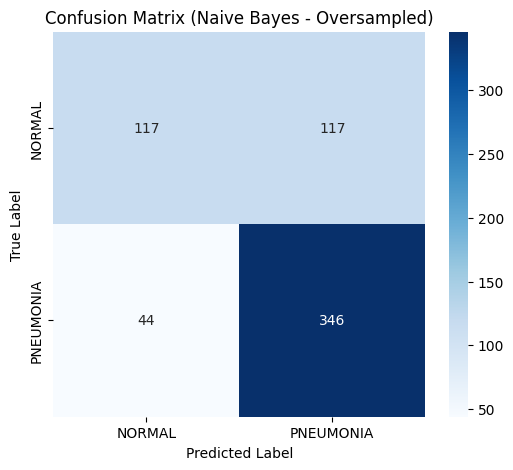

In [74]:

# Sur-échantillonnage des données
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sur-échantillonnage de la classe normal
X_train_normal_oversampled, y_train_normal_oversampled = resample(
    X_train_normal,
    labels["train"][labels["train"] == 0],
    replace=True,  # Permet de dupliquer les échantillons
    n_samples=X_train_pneumonia.shape[0],  # Égalise la taille de la classe "pneumonia"
    random_state=42
)

# Combiner les données sur-échantillonnées avec les données de la classe pneumonia
X_train_balanced_oversampled = np.vstack([X_train_normal_oversampled, X_train_pneumonia])
y_train_balanced_oversampled = np.hstack([y_train_normal_oversampled, labels["train"][labels["train"] == 1]])

# Standardisation des données
scaler = MinMaxScaler()
X_train_scaled_oversampled = scaler.fit_transform(X_train_balanced_oversampled)
X_test_scaled = scaler.transform(test_features)


# Entraîner le modèle final avec les meilleurs paramètres
nb_oversampled = GaussianNB()
nb_oversampled.fit(X_train_scaled_oversampled, y_train_balanced_oversampled)

# Évaluation sur le jeu de test
test_predictions_oversampled = nb_oversampled.predict(X_test_scaled)
test_accuracy_oversampled = accuracy_score(labels["test"], test_predictions_oversampled)

print(f"\nTest Accuracy (Naive Bayes - Oversampled): {test_accuracy_oversampled * 100:.2f}%")
print("\nClassification Report (Naive Bayes) on Test Set (Oversampled):")
print(classification_report(labels["test"], test_predictions_oversampled, target_names=["NORMAL", "PNEUMONIA"]))

# Matrice de confusion
cm_oversampled = confusion_matrix(labels["test"], test_predictions_oversampled)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_oversampled, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Naive Bayes - Oversampled)")
plt.show()


In [19]:
# One-hot encode the labels (required for ANN with categorical output)
train_labels_oh = to_categorical(labels["train"])
val_labels_oh = to_categorical(labels["val"])
test_labels_oh = to_categorical(labels["test"])

# Build the ANN
model = Sequential([
    Dense(256, activation='relu', input_shape=(train_features.shape[1],)),  # Input layer
    Dropout(0.3),  # Dropout for regularization
    Dense(128, activation='relu'),  # Hidden layer
    Dropout(0.3),
    Dense(2, activation='softmax')  # Output layer (2 classes: NORMAL vs PNEUMONIA)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_features, train_labels_oh, 
                    validation_data=(val_features, val_labels_oh), 
                    epochs=20, batch_size=32, verbose=1)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_features, test_labels_oh, verbose=0)
print(f"Test Accuracy (ANN): {test_accuracy * 100:.2f}%")


C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8965 - loss: 0.3653 - val_accuracy: 0.9375 - val_loss: 0.1847
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9709 - loss: 0.1167 - val_accuracy: 0.8750 - val_loss: 0.6281
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9814 - loss: 0.0654 - val_accuracy: 1.0000 - val_loss: 0.0145
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9874 - loss: 0.0487 - val_accuracy: 0.9375 - val_loss: 0.1200
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9926 - loss: 0.0301 - val_accuracy: 1.0000 - val_loss: 0.0398
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9958 - loss: 0.0154 - val_accuracy: 0.9375 - val_loss: 0.1325
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9970 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0592
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9953 - loss: 0.0125 - val_accu

# 2-HISTOGRAM feature

In [20]:
def extract_histogram_features(images, bins=32):
    hist_features = []

    for img in images:
        # Vérifier si l'image a 3 canaux (RGB), sinon ne pas convertir
        if img.ndim == 3 and img.shape[-1] == 3:  
            img = rgb2gray(img)  # Convertir en niveaux de gris
        
        # Normaliser l'image en [0,255] si elle est en float [0,1]
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        # Calculer l'histogramme
        hist, _ = np.histogram(img.flatten(), bins=bins, range=(0, 256))

        # Normalisation de l'histogramme (évite la division par zéro)
        hist_sum = hist.sum()
        if hist_sum > 0:
            hist = hist.astype(float) / hist_sum
        
        hist_features.append(hist)

    return np.array(hist_features)

In [21]:
# Dictionnaires pour stocker les caractéristiques et labels
data_hist = {"train": [], "test": [], "val": []}
labels_hist = {"train": [], "test": [], "val": []}

# Parcourir les dossiers train, test, val
for subdir in ["train", "test", "val"]:
    for category in ["NORMAL", "PNEUMONIA"]:
        folder_path = os.path.join("chest_xray", subdir, category)
        category_label = 0 if category == "NORMAL" else 1

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            
            # Charger l'image en tant que tableau NumPy
            img = imread(file_path)
            
            # Extraire les caractéristiques d'histogramme
            hist_features = extract_histogram_features([img])  # Mettre l'image dans une liste
            
            if hist_features is not None:  # Vérifier si l'extraction a réussi
                data_hist[subdir].append(hist_features[0])  # Extraire l'élément du tableau
                labels_hist[subdir].append(category_label)

# Convertir en numpy arrays
for key in data_hist:
    data_hist[key] = np.array(data_hist[key])
    labels_hist[key] = np.array(labels_hist[key])

print("Extraction des caractéristiques Histogram terminée !")
print(f"Train data shape: {data_hist['train'].shape}, Train labels shape: {labels_hist['train'].shape}")
print(f"Test data shape: {data_hist['test'].shape}, Test labels shape: {labels_hist['test'].shape}")
print(f"Validation data shape: {data_hist['val'].shape}, Validation labels shape: {labels_hist['val'].shape}")

Extraction des caractéristiques Histogram terminée !
Train data shape: (5216, 32), Train labels shape: (5216,)
Test data shape: (624, 32), Test labels shape: (624,)
Validation data shape: (16, 32), Validation labels shape: (16,)


## KNN for Hist

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data_hist["train"])
X_test = scaler.transform(data_hist["test"])
X_val = scaler.transform(data_hist["val"])
y_train = labels_hist["train"]
y_test = labels_hist["test"]
y_val = labels_hist["val"]

In [23]:
knn = KNeighborsClassifier(n_neighbors=5)  # k=5
knn.fit(X_train, y_train)

# Prédictions KNN
y_pred_knn_train = knn.predict(X_train)
y_pred_knn_test = knn.predict(X_test)
y_pred_knn_val = knn.predict(X_val)

In [24]:
print("📌 Accuracy - KNN :")
print(f"Train: {accuracy_score(y_train, y_pred_knn_train):.4f}")
print(f"Test: {accuracy_score(y_test, y_pred_knn_test):.4f}")
print(f"Validation: {accuracy_score(y_val, y_pred_knn_val):.4f}")
print("\n📌 Classification Report - KNN :")
print(classification_report(y_val, y_pred_knn_val, target_names=["NORMAL", "PNEUMONIA"]))

📌 Accuracy - KNN :
Train: 0.9243
Test: 0.7917
Validation: 0.5625

📌 Classification Report - KNN :
              precision    recall  f1-score   support

      NORMAL       1.00      0.12      0.22         8
   PNEUMONIA       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



## Naive bayes for Hist

In [25]:
nb = GaussianNB()
nb.fit(X_train, y_train)

# Prédictions Naïve Bayes
y_pred_nb_train = nb.predict(X_train)
y_pred_nb_test = nb.predict(X_test)
y_pred_nb_val = nb.predict(X_val)

In [26]:
print("\n📌 Accuracy - Naïve Bayes :")
print(f"Train: {accuracy_score(y_train, y_pred_nb_train):.4f}")
print(f"Test: {accuracy_score(y_test, y_pred_nb_test):.4f}")
print(f"Validation: {accuracy_score(y_val, y_pred_nb_val):.4f}")
print("\n📌 Classification Report - Naïve Bayes :")
print(classification_report(y_val, y_pred_nb_val, target_names=["NORMAL", "PNEUMONIA"]))


📌 Accuracy - Naïve Bayes :
Train: 0.8000
Test: 0.6859
Validation: 0.4375

📌 Classification Report - Naïve Bayes :
              precision    recall  f1-score   support

      NORMAL       0.33      0.12      0.18         8
   PNEUMONIA       0.46      0.75      0.57         8

    accuracy                           0.44        16
   macro avg       0.40      0.44      0.38        16
weighted avg       0.40      0.44      0.38        16



# 3-First order statistics 

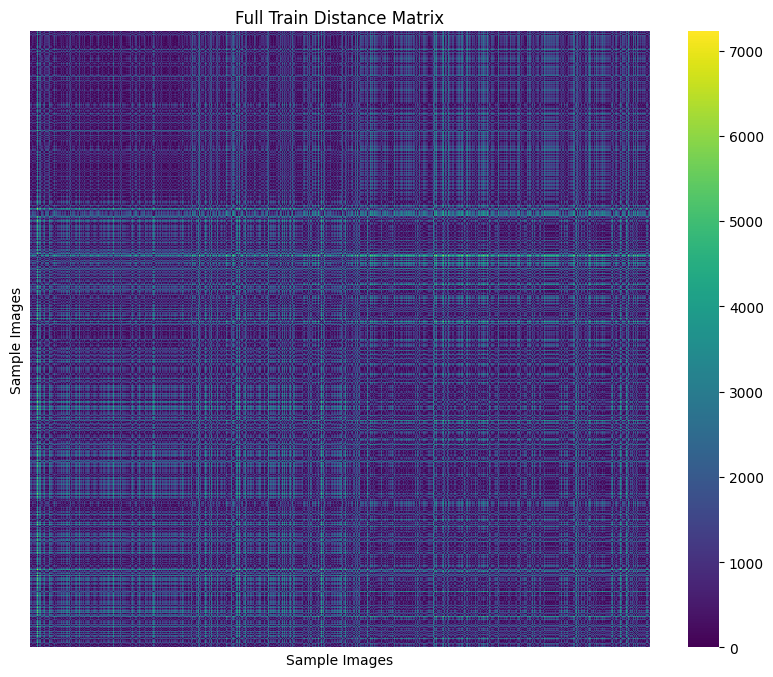

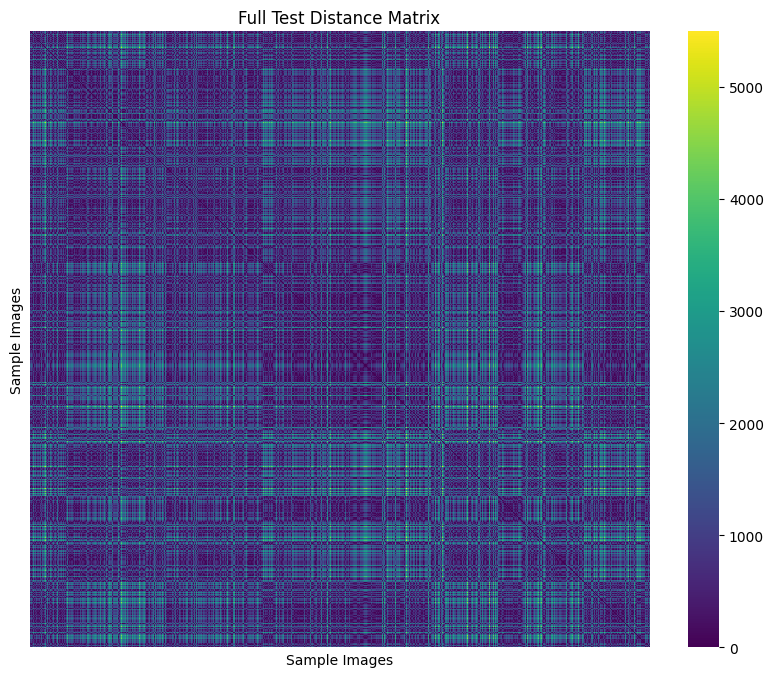

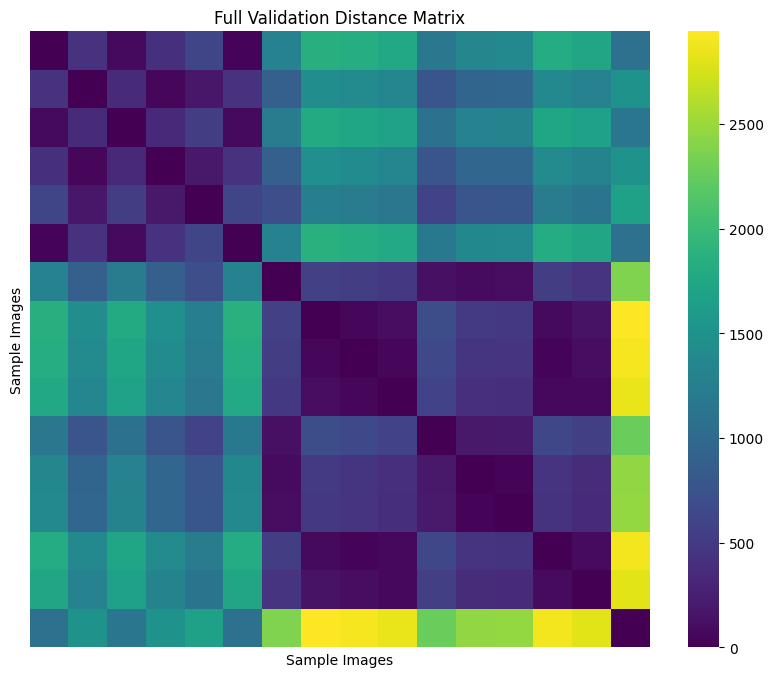

In [27]:

# Function to calculate first-order statistics
def calculate_first_order_features(image):
    pixels = image.flatten()  # Flatten the 2D array to 1D
    mean = np.mean(pixels)
    variance = np.var(pixels)
    std_dev = np.std(pixels)
    skewness = np.mean(((pixels - mean) / std_dev) ** 3)
    kurtosis = np.mean(((pixels - mean) / std_dev) ** 4) - 3
    min_val = np.min(pixels)
    max_val = np.max(pixels)
    return [mean, variance, std_dev, skewness, kurtosis, min_val, max_val]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Function to compute the pairwise distance matrix
def compute_distance_matrix(features):
    """
    Compute the pairwise distance matrix for the given features.
    """
    distances = squareform(pdist(features, metric='euclidean'))  # Use Euclidean distance
    return distances

# Function to plot the distance matrix
def plot_distance_matrix(distance_matrix, title):
    """
    Plot the distance matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Sample Images")
    plt.ylabel("Sample Images")
    plt.show()

# Dataset path
dataset_path = "chest_xray"
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Load images and compute first-order statistics
features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        for img in images:
            feature_vector = calculate_first_order_features(img)
            features[subdir].append(feature_vector)

# Convert to numpy arrays
features["train"] = np.array(features["train"])
features["test"] = np.array(features["test"])
features["val"] = np.array(features["val"])

# Compute and visualize the distance matrix for all train images
train_distance_matrix = compute_distance_matrix(features["train"])
plot_distance_matrix(train_distance_matrix, "Full Train Distance Matrix")

# Compute and visualize the distance matrix for all test images
test_distance_matrix = compute_distance_matrix(features["test"])
plot_distance_matrix(test_distance_matrix, "Full Test Distance Matrix")

# Compute and visualize the distance matrix for all validation images
val_distance_matrix = compute_distance_matrix(features["val"])
plot_distance_matrix(val_distance_matrix, "Full Validation Distance Matrix")


## KNN with first order feature

In [28]:
# Combine data and labels
X_train = features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

# Initialize and train the kNN classifier
k = 5  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = knn.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")


Confusion Matrix:
[[101 133]
 [ 72 318]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.58      0.43      0.50       234
   PNEUMONIA       0.71      0.82      0.76       390

    accuracy                           0.67       624
   macro avg       0.64      0.62      0.63       624
weighted avg       0.66      0.67      0.66       624


Accuracy: 67.15%

Validation Accuracy: 56.25%


## Naive bayes with first order feature

In [70]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

Confusion Matrix:
[[163  71]
 [150 240]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.52      0.70      0.60       234
   PNEUMONIA       0.77      0.62      0.68       390

    accuracy                           0.65       624
   macro avg       0.65      0.66      0.64       624
weighted avg       0.68      0.65      0.65       624


Accuracy: 64.58%

Validation Accuracy: 68.75%


# 4-GLCM

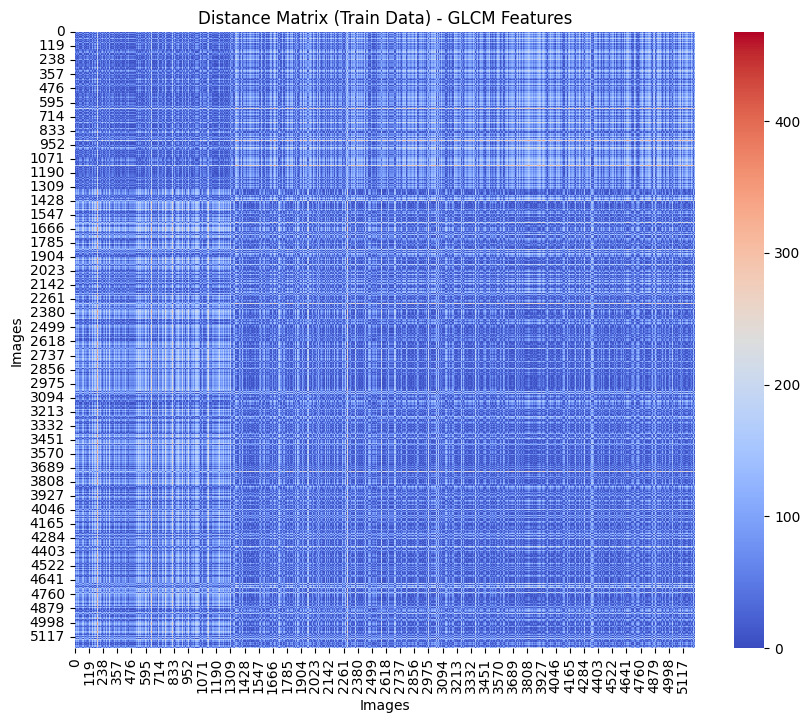

In [20]:

# Function to calculate GLCM features
def calculate_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    # Compute GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Extract features
    contrast = graycoprops(glcm, 'contrast').mean()  # Mean over all distances and angles
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    
    return [contrast, correlation, energy, homogeneity]

# Dataset path
dataset_path = "chest_xray"

# Define subdirectories and categories
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Open the image
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Load images and calculate GLCM features
data = {"train": [], "test": [], "val": []}
glcm_features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        # Compute GLCM features for each image
        for img in images:
            features = calculate_glcm_features(img)
            glcm_features[subdir].append(features)

# Convert to numpy arrays
glcm_features["train"] = np.array(glcm_features["train"])
glcm_features["test"] = np.array(glcm_features["test"])
glcm_features["val"] = np.array(glcm_features["val"])

# Example: Compute and visualize the distance matrix for train GLCM features
distance_matrix = cdist(glcm_features["train"], glcm_features["train"], metric="euclidean")

# Plot the heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", cbar=True)
plt.title("Distance Matrix (Train Data) - GLCM Features")
plt.xlabel("Images")
plt.ylabel("Images")
plt.show()


## KNN with glcm

In [66]:
# Combine data and labels
X_train = glcm_features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = glcm_features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = glcm_features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

# Initialize and train the kNN classifier
k = 5  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = knn.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")


Confusion Matrix:
[[107 127]
 [ 58 332]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.65      0.46      0.54       234
   PNEUMONIA       0.72      0.85      0.78       390

    accuracy                           0.70       624
   macro avg       0.69      0.65      0.66       624
weighted avg       0.70      0.70      0.69       624


Accuracy: 70.35%

Validation Accuracy: 62.50%


## Naive bayes with glcm

In [67]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

Confusion Matrix:
[[115 119]
 [ 47 343]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.71      0.49      0.58       234
   PNEUMONIA       0.74      0.88      0.81       390

    accuracy                           0.73       624
   macro avg       0.73      0.69      0.69       624
weighted avg       0.73      0.73      0.72       624


Accuracy: 73.40%

Validation Accuracy: 56.25%


# 5-Filtre de gabor

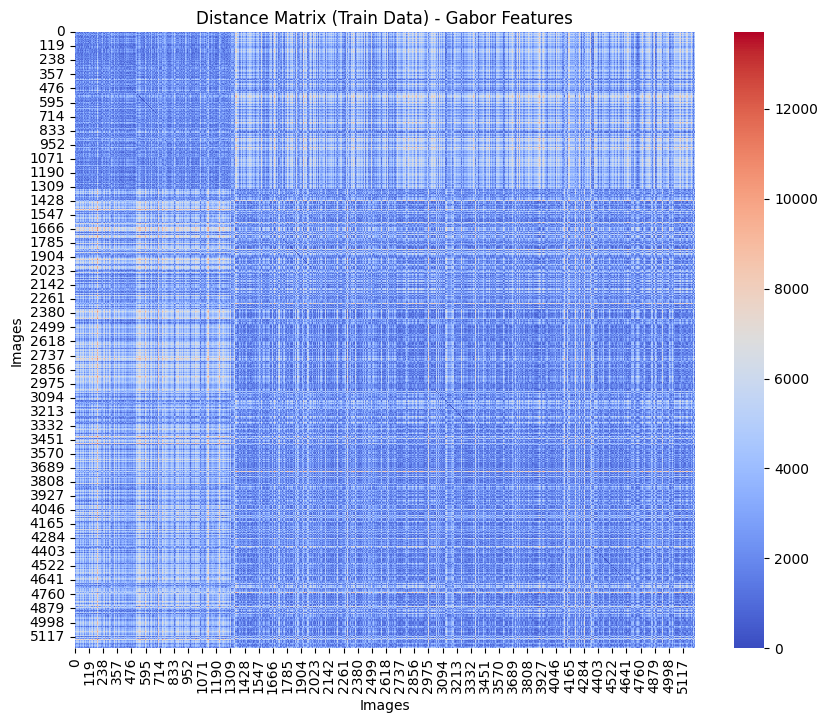

In [21]:

# Function to apply Gabor filter and extract features
def apply_gabor_filter(image, kernel_size=31, frequencies=[0.2, 0.4], thetas=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    features = []
    for freq in frequencies:
        for theta in thetas:
            # Create Gabor kernel
            kernel = cv2.getGaborKernel((kernel_size, kernel_size), 4.0, theta, 1.0 / freq, 0.5, 0, ktype=cv2.CV_32F)
            
            # Apply Gabor filter
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            
            # Extract features from the filtered image
            mean = np.mean(filtered)
            variance = np.var(filtered)
            features.extend([mean, variance])  # Add mean and variance to the feature vector
    return features

# Dataset path
dataset_path = "chest_xray"

# Define subdirectories and categories
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Open the image
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Load images and calculate Gabor filter features
data = {"train": [], "test": [], "val": []}
gabor_features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        # Compute Gabor filter features for each image
        for img in images:
            features = apply_gabor_filter(img)
            gabor_features[subdir].append(features)

# Convert to numpy arrays
gabor_features["train"] = np.array(gabor_features["train"])
gabor_features["test"] = np.array(gabor_features["test"])
gabor_features["val"] = np.array(gabor_features["val"])

# Example: Compute and visualize the distance matrix for train Gabor features
distance_matrix = cdist(gabor_features["train"], gabor_features["train"], metric="euclidean")

# Plot the heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", cbar=True)
plt.title("Distance Matrix (Train Data) - Gabor Features")
plt.xlabel("Images")
plt.ylabel("Images")
plt.show()


## KNN with Gabor feature

In [ ]:
# Combine data and labels
X_train = gabor_features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = gabor_features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = gabor_features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

# Initialize and train the kNN classifier
k = 5  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = knn.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")


Confusion Matrix:
[[ 74 160]
 [ 41 349]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.64      0.32      0.42       234
   PNEUMONIA       0.69      0.89      0.78       390

    accuracy                           0.68       624
   macro avg       0.66      0.61      0.60       624
weighted avg       0.67      0.68      0.64       624


Accuracy: 67.79%

Validation Accuracy: 68.75%


## Naive bayes with gabor feature

In [56]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

Confusion Matrix:
[[134 100]
 [ 77 313]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.64      0.57      0.60       234
   PNEUMONIA       0.76      0.80      0.78       390

    accuracy                           0.72       624
   macro avg       0.70      0.69      0.69       624
weighted avg       0.71      0.72      0.71       624


Accuracy: 71.63%

Validation Accuracy: 62.50%


# 6-LBP feature

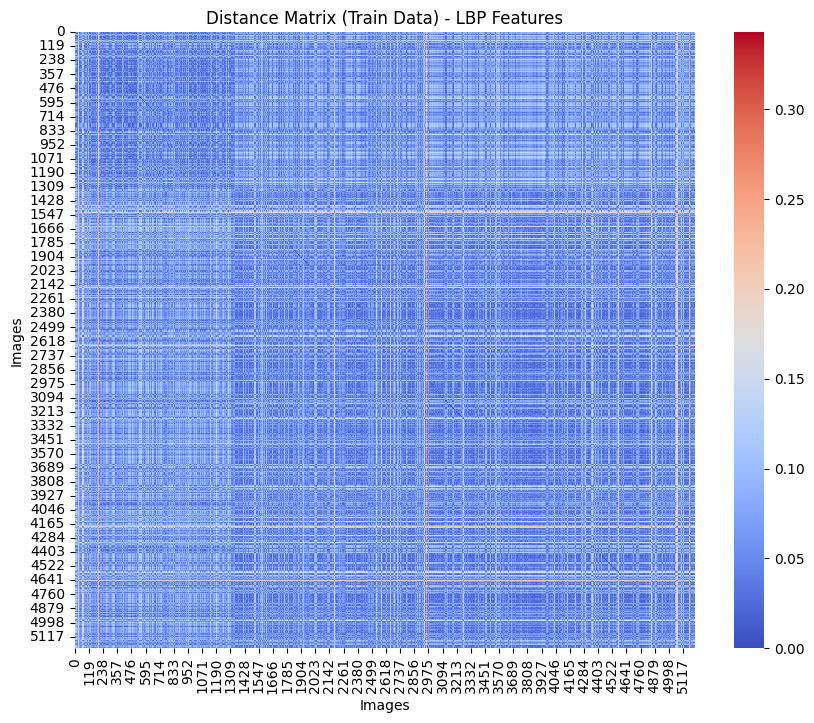

In [24]:

# Function to compute LBP features
def calculate_lbp_features(image, P=8, R=1):
    # Compute LBP
    lbp = local_binary_pattern(image, P=P, R=R, method="uniform")
    # Compute histogram of LBP
    n_bins = P + 2  # Uniform patterns + 1 for others
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    # Normalize histogram
    hist = hist / hist.sum()
    return hist

# Dataset path
dataset_path = "chest_xray"

# Define subdirectories and categories
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Open the image
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Load images and calculate LBP features
data = {"train": [], "test": [], "val": []}
lbp_features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        # Compute LBP features for each image
        for img in images:
            features = calculate_lbp_features(img)
            lbp_features[subdir].append(features)

# Convert to numpy arrays
lbp_features["train"] = np.array(lbp_features["train"])
lbp_features["test"] = np.array(lbp_features["test"])
lbp_features["val"] = np.array(lbp_features["val"])

# Example: Compute and visualize the distance matrix for train LBP features
distance_matrix = cdist(lbp_features["train"], lbp_features["train"], metric="euclidean")

# Plot the heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", cbar=True)
plt.title("Distance Matrix (Train Data) - LBP Features")
plt.xlabel("Images")
plt.ylabel("Images")
plt.show()


## KNN with LBP feature

In [ ]:


# Combine data and labels
X_train = lbp_features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = lbp_features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = lbp_features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

# Initialize and train the kNN classifier
k = 5  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = knn.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")


Confusion Matrix:
[[105 129]
 [ 31 359]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.77      0.45      0.57       234
   PNEUMONIA       0.74      0.92      0.82       390

    accuracy                           0.74       624
   macro avg       0.75      0.68      0.69       624
weighted avg       0.75      0.74      0.72       624


Accuracy: 74.36%

Validation Accuracy: 75.00%


## Naive bayes with LBP feature

In [26]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

Confusion Matrix:
[[101 133]
 [ 64 326]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.61      0.43      0.51       234
   PNEUMONIA       0.71      0.84      0.77       390

    accuracy                           0.68       624
   macro avg       0.66      0.63      0.64       624
weighted avg       0.67      0.68      0.67       624


Accuracy: 68.43%

Validation Accuracy: 75.00%


# Combained features

In [65]:
combined_features = {}
for subdir in subdirs:
    combined_features[subdir] = np.concatenate((data_hist[subdir], lbp_features[subdir], glcm_features[subdir], gabor_features[subdir]), axis=1)

# Normalisation des données combinées
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_features["train"])
X_test = scaler.transform(combined_features["test"])
X_val = scaler.transform(combined_features["val"])
y_train = labels_hist["train"]  # Utilisez les labels des histogrammes (identiques pour LBP)
y_test = labels_hist["test"]
y_val = labels_hist["val"]

# Entraînement et évaluation du classificateur kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn_train = knn.predict(X_train)
y_pred_knn_test = knn.predict(X_test)
y_pred_knn_val = knn.predict(X_val)

print("Evaluation sur le test:")
print(classification_report(y_test, y_pred_knn_test))
print(confusion_matrix(y_test, y_pred_knn_test))

print("Evaluation sur la validation:")
print(classification_report(y_val, y_pred_knn_val))
print(confusion_matrix(y_val, y_pred_knn_val))


Evaluation sur le test:
              precision    recall  f1-score   support

           0       0.82      0.56      0.67       234
           1       0.78      0.93      0.85       390

    accuracy                           0.79       624
   macro avg       0.80      0.75      0.76       624
weighted avg       0.80      0.79      0.78       624

[[132 102]
 [ 28 362]]
Evaluation sur la validation:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

[[1 7]
 [0 8]]


# Model CNN

In [29]:

# Charger le processeur d'images
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# Charger le modèle ViT pré-entraîné
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Transformations des images
transform = transforms.Compose([
    transforms.Grayscale(),  # Convertir en niveaux de gris
    transforms.Resize((128, 128)),  # Redimensionner
    transforms.ToTensor(),  # Convertir en tenseur PyTorch
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation
])

# Charger le dataset avec ImageFolder
train_dataset = datasets.ImageFolder(root="chest_xray/train", transform=transform)
val_dataset = datasets.ImageFolder(root="chest_xray/val", transform=transform)

# Utiliser un DataLoader pour charger par batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [36]:

# Charger le modèle pré-entraîné ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modifier la première couche (car images en niveaux de gris, pas RGB)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modifier la dernière couche pour correspondre à 2 classes (Normal/Pneumonia)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes

# Envoyer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Envoyer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [37]:

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [38]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Mode entraînement
        running_loss = 0.0
        correct = 0
        total = 0

        # Boucle sur les batches d'entraînement
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Réinitialiser les gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Mise à jour des poids

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Époque {epoch+1}, Perte : {running_loss:.4f}, Exactitude : {train_acc:.2f}%")

        # Validation après chaque époque
        validate_model(model, val_loader, criterion)

def validate_model(model, val_loader, criterion):
    model.eval()  # Mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Validation - Perte : {val_loss:.4f}, Exactitude : {val_acc:.2f}%")


In [42]:
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


100%|██████████| 163/163 [02:35<00:00,  1.05it/s]


Époque 1, Perte : 20.6722, Exactitude : 95.61%
Validation - Perte : 0.9792, Exactitude : 62.50%


100%|██████████| 163/163 [02:33<00:00,  1.06it/s]


Époque 2, Perte : 12.8209, Exactitude : 97.05%
Validation - Perte : 0.3884, Exactitude : 81.25%


100%|██████████| 163/163 [02:33<00:00,  1.07it/s]


Époque 3, Perte : 8.9645, Exactitude : 97.99%
Validation - Perte : 0.2060, Exactitude : 87.50%


100%|██████████| 163/163 [02:23<00:00,  1.14it/s]


Époque 4, Perte : 7.0210, Exactitude : 98.37%
Validation - Perte : 0.5177, Exactitude : 81.25%


100%|██████████| 163/163 [02:16<00:00,  1.19it/s]


Époque 5, Perte : 6.5698, Exactitude : 98.56%
Validation - Perte : 0.8432, Exactitude : 68.75%


100%|██████████| 163/163 [02:17<00:00,  1.18it/s]


Époque 6, Perte : 5.7232, Exactitude : 98.66%
Validation - Perte : 1.0146, Exactitude : 62.50%


100%|██████████| 163/163 [02:20<00:00,  1.16it/s]


Époque 7, Perte : 5.2818, Exactitude : 98.93%
Validation - Perte : 0.9452, Exactitude : 75.00%


100%|██████████| 163/163 [02:20<00:00,  1.16it/s]


Époque 8, Perte : 4.3218, Exactitude : 99.18%
Validation - Perte : 0.0682, Exactitude : 100.00%


100%|██████████| 163/163 [02:30<00:00,  1.08it/s]


Époque 9, Perte : 1.9730, Exactitude : 99.60%
Validation - Perte : 0.0504, Exactitude : 100.00%


100%|██████████| 163/163 [02:53<00:00,  1.06s/it]


Époque 10, Perte : 4.2311, Exactitude : 99.08%
Validation - Perte : 0.1508, Exactitude : 87.50%


In [58]:

def predict_image(model, image_path):
    model.eval()
    
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension batch

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_names = ["NORMAL", "PNEUMONIA"]
    return class_names[predicted.item()]

image_path = "chest_xray/test/PNEUMONIA/person78_bacteria_378.jpeg"
prediction = predict_image(model, image_path)
print(f"Prédiction : {prediction}")


Prédiction : PNEUMONIA


In [62]:

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=["NORMAL", "PNEUMONIA"]))

# Évaluer le modèle sur le set de test
evaluate_model(model, val_loader)


              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



🔍 Analyse des résultats

✅ Accuracy = 94% → Très bon score, mais il faut vérifier si le modèle est équilibré.

✅ Precision & Recall élevés → Le modèle généralise bien et fait peu d'erreurs.

✅ F1-score ≈ 0.94 → Bon équilibre entre précision et rappel.

📌 Détails par classe :

NORMAL (Précision = 1.00, Rappel = 0.88)

✅ Aucun faux positif (précision parfaite).

❌ Mais il manque 12% des vrais cas normaux (faux négatifs).

PNEUMONIA (Précision = 0.89, Rappel = 1.00)

❌ 11% de faux positifs (précision < 1).

✅ Aucun cas de pneumonie raté (rappel parfait).

In [61]:
# Sauvegarder le modèle
#torch.save(model.state_dict(), "model_cnn.pth")

# Charger le modèle
model.load_state_dict(torch.load("model_cnn.pth"))
model.to(device)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Handling Data imbalance 

In [55]:
total_samples = COUNT_NORMAL['train'] + COUNT_PNEUMONIA['train']

# Calculate class weights (inverse frequency of each class)
weight_normal = total_samples / COUNT_NORMAL['train']
weight_pneumonia = total_samples / COUNT_PNEUMONIA['train']

# Create the class weights tensor
class_weights = torch.tensor([weight_normal, weight_pneumonia]).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [56]:
# Define optimizer (if needed)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (same as before)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Use the class-weighted loss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/10], Loss: 7.8780, Accuracy: 98.41%
Epoch [2/10], Loss: 3.0291, Accuracy: 99.21%
Epoch [3/10], Loss: 5.7812, Accuracy: 98.75%
Epoch [4/10], Loss: 2.9762, Accuracy: 99.25%
Epoch [5/10], Loss: 4.6928, Accuracy: 98.89%
Epoch [6/10], Loss: 2.9944, Accuracy: 99.42%
Epoch [7/10], Loss: 0.5986, Accuracy: 99.83%
Epoch [8/10], Loss: 0.3101, Accuracy: 99.94%
Epoch [9/10], Loss: 4.3570, Accuracy: 99.39%
Epoch [10/10], Loss: 4.5073, Accuracy: 99.16%


In [63]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    val_acc = 100 * correct / total

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["NORMAL", "PNEUMONIA"]))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# Call the evaluation function
evaluate_model(model, val_loader)


Validation Loss: 0.2637, Accuracy: 93.75%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


Confusion Matrix:
[[7 1]
 [0 8]]


In [64]:
torch.save(model.state_dict(), "model_cnn.pth")

# Data augmentation

In [ ]:

# Get class distribution in training set
train_classes = [label for _, label in train_dataset]
class_counts = Counter(train_classes)

print("Class Distribution in Training Set:", train_dataset.class_to_idx)
print("Class Counts:", class_counts)


Class Distribution in Training Set: {'NORMAL': 0, 'PNEUMONIA': 1}
Class Counts: Counter({1: 3875, 0: 1341})


In [69]:
# Define augmentations (apply only to minority class)
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, minority_class, augment_factor=2):
        self.dataset = dataset
        self.minority_class = minority_class
        self.augment_factor = augment_factor  # Number of extra augmented copies
        
        # Split dataset into majority and minority samples
        self.minority_samples = [sample for sample in dataset if sample[1] == minority_class]
        self.majority_samples = [sample for sample in dataset if sample[1] != minority_class]

        # Augment minority class
        self.augmented_samples = []
        for img_tensor, label in self.minority_samples:
            img_pil = F.to_pil_image(img_tensor)  # Convert tensor to PIL image
            for _ in range(augment_factor):
                aug_img = augment_transform(img_pil)  # Apply augmentation
                self.augmented_samples.append((aug_img, label))

        # Combine original and augmented data
        self.new_data = self.majority_samples + self.minority_samples + self.augmented_samples

    def __len__(self):
        return len(self.new_data)

    def __getitem__(self, idx):
        return self.new_data[idx]

# Find the minority class
minority_class = min(class_counts, key=class_counts.get)

# Apply augmentation
augmented_train_dataset = AugmentedDataset(train_dataset, minority_class, augment_factor=3)

# Use the new dataset in DataLoader
train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)


In [72]:
# Train the model with augmented dataset
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

100%|██████████| 289/289 [03:14<00:00,  1.49it/s]


Époque 1, Perte : 26.7231, Exactitude : 95.14%
Validation - Perte : 0.0982, Exactitude : 93.75%


100%|██████████| 289/289 [02:51<00:00,  1.69it/s]


Époque 2, Perte : 7.4712, Exactitude : 98.57%
Validation - Perte : 0.1753, Exactitude : 100.00%


100%|██████████| 289/289 [02:53<00:00,  1.66it/s]


Époque 3, Perte : 4.9098, Exactitude : 99.10%
Validation - Perte : 0.3071, Exactitude : 87.50%


100%|██████████| 289/289 [02:50<00:00,  1.69it/s]


Époque 4, Perte : 3.7511, Exactitude : 99.26%
Validation - Perte : 0.2013, Exactitude : 100.00%


100%|██████████| 289/289 [02:50<00:00,  1.70it/s]


Époque 5, Perte : 3.0450, Exactitude : 99.47%
Validation - Perte : 0.0199, Exactitude : 100.00%


100%|██████████| 289/289 [02:50<00:00,  1.69it/s]


Époque 6, Perte : 2.8110, Exactitude : 99.48%
Validation - Perte : 2.1876, Exactitude : 56.25%


100%|██████████| 289/289 [02:50<00:00,  1.69it/s]


Époque 7, Perte : 2.9597, Exactitude : 99.50%
Validation - Perte : 0.5783, Exactitude : 81.25%


100%|██████████| 289/289 [02:50<00:00,  1.69it/s]


Époque 8, Perte : 5.4611, Exactitude : 99.14%
Validation - Perte : 0.1152, Exactitude : 87.50%


100%|██████████| 289/289 [02:50<00:00,  1.69it/s]


Époque 9, Perte : 2.5244, Exactitude : 99.51%
Validation - Perte : 0.5237, Exactitude : 93.75%


100%|██████████| 289/289 [02:51<00:00,  1.68it/s]


Époque 10, Perte : 2.3645, Exactitude : 99.61%
Validation - Perte : 0.1253, Exactitude : 93.75%


In [73]:
# Evaluate the model after training
evaluate_model(model, val_loader)


Validation Loss: 0.1253, Accuracy: 93.75%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


Confusion Matrix:
[[7 1]
 [0 8]]
